In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1
FORCE_REWRITE = True

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
if not ON_KAGGLE and '.' not in sys.path:
    sys.path.append('.')
from src.metrics import *
from src.data import merge_asset_details, get_data_for_asset
from src.cv import TimeSeriesSplit, get_date_range
from src.modeling import Evaluator
from src.metrics import compute_metrics, compute_correlation
from src.pipeline.feature_gen import compute_instant_features
from src.data import infer_dtypes
from src.pipeline import EXPECTED_RAW_COLS
from src.pipeline.transforms import FilterFeatures
from src.modeling import Evaluator
from src.util import setup_dir
from src.training import compute_exp_time_weight

In [7]:
DATA_DIR, RAW_TRAIN_DIR = setup_dir(ON_KAGGLE, sample_level=SAMPLE_LEVEL)
RAW_TRAIN_PATH = RAW_TRAIN_DIR / 'train.csv'
ASSET_DETAILS_PATH = DATA_DIR / 'asset_details.csv'

In [8]:
RAW_TRAIN_DIR

PosixPath('data/raw/sample/1')

In [9]:
DATA_DIR

PosixPath('data/raw')

In [10]:
%%time 
raw_data = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 3.77 s, sys: 268 ms, total: 4.04 s
Wall time: 4.04 s


## create train set

In [11]:
MAIN_INDEX = ['timestamp', 'Asset_ID']

In [12]:
# get valid data only, drop where the target is NaN 
raw_data = raw_data.dropna(subset=['Target'])
# format time to human readable 
raw_data['time'] = pd.to_datetime(raw_data['timestamp'], unit='s')
# merge asset names
raw_data = merge_asset_details(raw_data, ASSET_DETAILS_PATH)

In [13]:
raw_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1609459260,3,104.0,0.181465,0.181702,0.181270,0.181493,6.134333e+05,0.181527,0.001255,2021-01-01 00:01:00,Cardano
1,1609459260,2,275.0,342.556667,343.500000,342.420000,342.966667,4.199310e+02,342.842188,-0.002884,2021-01-01 00:01:00,Bitcoin Cash
2,1609459260,0,219.0,37.385000,37.422100,37.348700,37.389000,2.749569e+03,37.387059,-0.001669,2021-01-01 00:01:00,Binance Coin
3,1609459260,1,4039.0,28985.511250,29086.900000,28960.000000,29032.387500,1.637870e+02,29017.664870,0.000396,2021-01-01 00:01:00,Bitcoin
4,1609459260,4,84.0,0.004671,0.004683,0.004668,0.004677,2.202482e+06,0.004675,-0.008679,2021-01-01 00:01:00,Dogecoin


In [14]:
raw_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
5137881,1631491200,9,176.0,183.043333,183.240000,182.94000,183.118833,1.127703e+03,183.079643,0.003215,2021-09-13,Litecoin
5137882,1631491200,10,15.0,2872.870767,2876.000000,2872.33870,2874.284467,9.084150e-01,2872.969592,0.005277,2021-09-13,Maker
5137883,1631491200,13,873.0,0.112415,0.112522,0.11229,0.112390,3.465484e+06,0.112399,0.007712,2021-09-13,TRON
5137884,1631491200,12,200.0,0.332417,0.332900,0.33197,0.332570,1.875167e+05,0.332414,0.003338,2021-09-13,Stellar
5137885,1631491200,11,7.0,256.317500,256.440000,256.20000,256.292500,1.234097e+00,256.303736,0.003787,2021-09-13,Monero


In [15]:
raw_data = infer_dtypes(raw_data)

In [16]:
raw_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,Asset_Name
0,1609459260,3,104.0,0.181465,0.181702,0.181270,0.181493,6.134333e+05,0.181527,0.001255,2021-01-01 00:01:00,Cardano
1,1609459260,2,275.0,342.556671,343.500000,342.420013,342.966675,4.199310e+02,342.842194,-0.002884,2021-01-01 00:01:00,Bitcoin Cash
2,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2.749569e+03,37.387058,-0.001669,2021-01-01 00:01:00,Binance Coin
3,1609459260,1,4039.0,28985.511719,29086.900391,28960.000000,29032.386719,1.637870e+02,29017.664062,0.000396,2021-01-01 00:01:00,Bitcoin
4,1609459260,4,84.0,0.004671,0.004683,0.004668,0.004677,2.202482e+06,0.004675,-0.008679,2021-01-01 00:01:00,Dogecoin


In [17]:
FEATURES = [
'Count',
'High',
'Low',
'Close',
'Volume',
'VWAP',
'high_low_return',
'open_close_return',
'upper_shadow',
'lower_shadow',
'dolar_amount',
'vol_per_trades'
]

In [18]:
PRIVATE_LB_RANGE = [['2020-01-01', '2020-04-01']]
PULIC_LB_RANGE = ['2021-06-13',
                  '2021-09-13'] # 3 MONTH WORTH OF DATA


if SAMPLE_LEVEL==2:
    EVAL_PERIODS = [['2021-09-11', '2021-09-13']]
elif SAMPLE_LEVEL == 1:
    EVAL_PERIODS = [PULIC_LB_RANGE]
else:
    EVAL_PERIODS =  [
                     ['2020-01-01', '2020-04-01'],
                     ['2020-09-01', '2021-01-01'],
                     ['2021-01-01', '2021-04-01'],
                     ['2021-04-01', '2021-07-01']
                     ]

In [19]:
EVAL_PERIODS

[['2021-06-13', '2021-09-13']]

In [20]:
def _create_fi_pd(features, importances):
    return (pd.DataFrame({'feature': features, 'importance': importances})
            .sort_values(by=['importance']).reset_index(drop=True))

def compute_fi(config, model, valid_data):
    return _create_fi_pd(model['filter'].features, model['model'].coef_)

In [22]:
CV_PARAMS = {'gap_unit': 'min', 'dt_col': 'time'}


CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)
asset_ids = raw_data['Asset_ID'].unique()

In [30]:
data = compute_instant_features(raw_data)

In [38]:
data=data.rename(columns={f: 'ft_' + f for f in FEATURES})

In [71]:
MODEL_CONFIG = {'instance': 'rigde', 'parameters': {'alpha': 0.001}}
TRAIN_CONFIG = {'exp_time_weight': None,
                'target_tmf': None}
TARGET_TMF_CONFIG = None
CONFIG = {'model': MODEL_CONFIG,
          'training': TRAIN_CONFIG,
          'target': 'Target'}

In [86]:
MODEL_CONFIG = {'instance': 'rigde',
                'parameters': {'alpha': 0.001}
               }
TRAIN_CONFIG = {'exp_time_weight': None,
                'target_tmf': None}
TARGET_TMF_CONFIG = None
CONFIG = {'model': MODEL_CONFIG,
          'training': TRAIN_CONFIG,
          'target': 'Target'}

In [87]:
from src.training import run_experiment
from src.model import MODEL_DISPATCHER

In [88]:
def train_sklearn_model(config, train_features, train_target, train_sample_weight, *args, **kwargs):
    model = MODEL_DISPATCHER.get(config['model'])
    model.fit(train_features, train_target, model__sample_weight=train_sample_weight)
    return model

In [89]:
from collections import defaultdict
output_exp = defaultdict(list)

for asset_id in asset_ids:
    asset_data = get_data_for_asset(data, asset_id)
    for fold, (train_idx, valid_idx) in enumerate(CV.split(asset_data)):
        asset_data['model_group'] = np.nan
        asset_data.loc[train_idx, 'model_group'] = 'train'
        asset_data.loc[valid_idx, 'model_group'] = 'test'  
        fold_output_exp = run_experiment(CONFIG, train_sklearn_model, asset_data)
        fold_output_exp['inference']['fold'] = fold
        output_exp[asset_id].append(fold_output_exp)
        asset_data.drop('model_group', axis=1, inplace=True)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [90]:
inference_df = pd.concat([fold_out['inference']
                          for folds in output_exp.values()
                          for fold_out in folds])

In [91]:
scores = inference_df.groupby('fold').apply(compute_metrics).reset_index()
scores['eval_period'] = EVAL_PERIODS

In [92]:
scores

,fold,corr,crypto_consistency,sharpe,corr_period_mean,corr_period_std,consistency,min_period_corr,corr_min,corr_max,corr_std,eval_period
0,0,0.006694,8.0,0.958752,0.009744,0.010163,0.785714,-0.006443,-0.028497,0.043336,0.018661,"[2021-06-13, 2021-09-13]"


In [28]:
scores

,fold,corr,crypto_consistency,sharpe,corr_period_mean,corr_period_std,consistency,min_period_corr,corr_min,corr_max,corr_std,eval_period
0,0,0.013819,11.0,0.718155,0.012036,0.016759,0.857143,-0.016149,-0.010554,0.067012,0.022283,"[2021-06-13, 2021-09-13]"


In [29]:
print('|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |\n|---:|-------:|-----------:|---------------------:|------------:|-------------------:|\n|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |\n|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |\n|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |\n|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |')

|    |   fold |       corr |   crypto_consistency |      sharpe |   corr_period_mean |
|---:|-------:|-----------:|---------------------:|------------:|-------------------:|
|  0 |      0 | 0.0340875  |                   12 |  0.891724   |        0.0140149   |
|  1 |      1 | 0.00107583 |                   11 | -0.00378112 |       -6.72739e-05 |
|  2 |      2 | 0.00639626 |                   10 |  0.730508   |        0.0114782   |
|  3 |      3 | 0.00803942 |                   10 |  0.333772   |        0.00654437  |


In [93]:
scores.mean()

fold                  0.000000
corr                  0.006694
crypto_consistency    8.000000
sharpe                0.958752
corr_period_mean      0.009744
corr_period_std       0.010163
consistency           0.785714
min_period_corr      -0.006443
corr_min             -0.028497
corr_max              0.043336
corr_std              0.018661
dtype: float64

fold                   1.500000
corr                   0.012400
crypto_consistency    10.750000
sharpe                 0.488056
corr_period_mean       0.007993
corr_period_std        0.017207
consistency            0.768162
min_period_corr       -0.018003
corr_min              -0.027406
corr_max               0.064634
corr_std               0.023568
dtype: float64

In [31]:
corrs_fold = inference_df.groupby('fold').apply(lambda d: compute_correlation(d, group_col='Asset_Name').set_index("Asset_Name")).unstack().T

corrs_fold['cum_corr'] = corrs_fold.mean(axis=1)

In [32]:
corrs_fold = corrs_fold.sort_values(by='cum_corr')

In [33]:
corrs_fold

fold                          0  cum_corr
     Asset_Name                          
corr Bitcoin Cash     -0.010554 -0.010554
     Stellar          -0.007033 -0.007033
     Ethereum         -0.005957 -0.005957
     Litecoin          0.006759  0.006759
     Ethereum Classic  0.008186  0.008186
     Dogecoin          0.009271  0.009271
     Monero            0.010632  0.010632
     Maker             0.011698  0.011698
     Bitcoin           0.013960  0.013960
     EOS.IO            0.018357  0.018357
     Binance Coin      0.023846  0.023846
     IOTA              0.037151  0.037151
     Cardano           0.053263  0.053263
     TRON              0.067012  0.067012

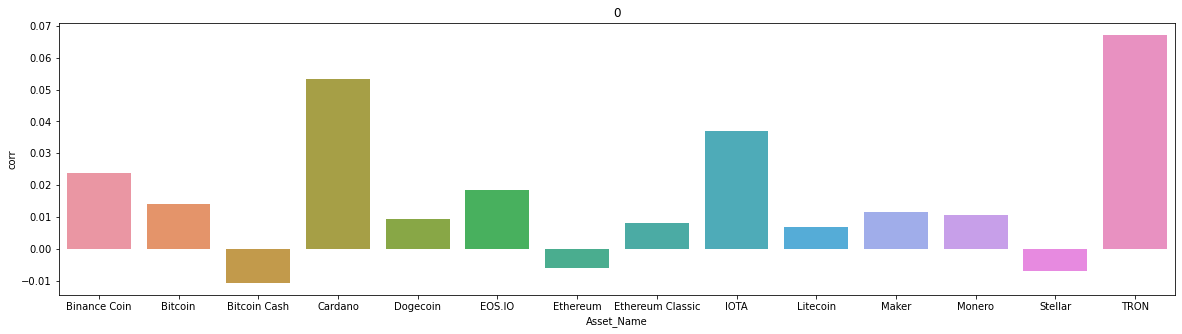

In [34]:
for fold, fold_data in inference_df.groupby('fold'):
    corrs = compute_correlation(fold_data, group_col='Asset_Name')
    plt.figure(figsize=(20, 5))
    sns.barplot(x='Asset_Name', y='corr', data=corrs)
    plt.title(fold)